#### Example of estimating categorical priors and adjusting classifier predictions from our paper
# Improving CNN classifiers by estimating test-time priors
## Milan Sulc, Jiri Matas
### The IEEE International Conference on Computer Vision (ICCV) Workshops (TASK-CV 2019)


http://openaccess.thecvf.com/content_ICCVW_2019/papers/TASK-CV/Sulc_Improving_CNN_Classifiers_by_Estimating_Test-Time_Priors_ICCVW_2019_paper.pdf

In [1]:
import numpy as np 
import copy
import matplotlib.pyplot as plt


In this example, we work with predictions ([test_set_predictions.npy](http://cmp.felk.cvut.cz/~sulcmila/priors/test_set_predictions.npy)) from a model that has been trained on a subset of CIFAR-100 with an unbalanced class distribution ([label_distribution_on_training_set.npy](http://cmp.felk.cvut.cz/~sulcmila/priors/label_distribution_on_training_set.npy)).

(0, 100)

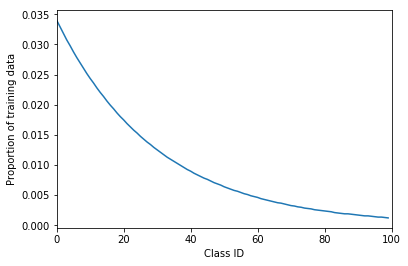

In [2]:
train_set_path = 'label_distribution_on_training_set.npy'
predictions_path = 'test_set_predictions.npy'

train_set_distribution = np.load(train_set_path)
train_set_distribution = train_set_distribution / sum(train_set_distribution)
predictions, gt = np.load(predictions_path)
test_set_distribution = np.ones_like(train_set_distribution) / len(train_set_distribution) # in this example, test set distribution is uniform

plt.plot(train_set_distribution)
plt.xlabel("Class ID")
plt.ylabel("Proportion of training data")
plt.xlim(0,100)

In [3]:
# EM algorithm proposed in
# Du Plessis, Marthinus Christoffel, and Masashi Sugiyama. "Semi-supervised learning of class balance under class-prior change by distribution matching." Neural Networks 50 (2014): 110-119.
# https://arxiv.org/pdf/1206.4677

def correct_predictions(predictions, train_set_distribution, test_set_distribution=None):
    """ Correct estimates of posterior probabilities (from the classifier),
        knowing the training set distribution and a different test set distribution.
        I.e. predictions are multiplied by the ratio of class priors.
        
    Args:
        predictions: numpy array (num_classes, num_data) with predictions
        train_set_distribution: numpy array (num_classes,)
        test_set_distribution: numpy array (num_classes,); if None - use uniform distribution
    Returns:
        corrected_predictions: numpy array (num_classes, num_data) with corrected predictions
    """
    
    if test_set_distribution is None:
        test_set_distribution = np.ones(train_set_distribution.shape)
    corrected_predictions = predictions * test_set_distribution[:,None] / train_set_distribution[:,None]
    corrected_predictions = corrected_predictions / np.sum(corrected_predictions, axis=0) # normalize to sum to 1
    return corrected_predictions


def estimate_priors_from_predictions(predictions):
    """ Estimate class priors from predictions.
        
    Args:
        predictions: numpy array (num_classes, num_data) with predictions
    Returns:
        priors: numpy array (num_classes) with estimated class priors
    """
    
    priors = np.mean(predictions, axis=1)
    return priors


def iteratively_correct_predictions(predictions, train_set_distribution, test_init_distribution=None, termination_difference=0.001, verbose=False):
    """ Correct estimates of posterior probabilities (from the classifier),
        knowing the training set distribution only;
        using and EM algorithm for test set distribution estimation.
        
    Args:
        predictions: numpy array (num_classes, num_data) with predictions
        train_set_distribution: numpy array (num_classes,) with the train set distribution
        test_init_distribution: numpy array (num_classes,) to initialize test set distribution.
                                If None, use train_set_distribution.
        termination_error: float defining the distance of posterior predictions for termination.
    Returns:
        new_predictions: numpy array (num_classes, num_data) with corrected predictions
        new_test_set_distribution: numpy array (num_classes,) with the estimated test set distribution
    """
    if test_init_distribution is None:
        test_init_distribution = np.copy(train_set_distribution)
        
    test_set_distribution = test_init_distribution / np.sum(test_init_distribution)
    step = 0

    while True:
        step += 1
        new_predictions = correct_predictions(predictions, train_set_distribution, test_set_distribution)
        new_test_set_distribution = estimate_priors_from_predictions(new_predictions)

        difference = np.sum(np.square(new_test_set_distribution - test_set_distribution))
        if verbose: print("EM step ", step, "; diff. %.8f" % (difference))
        if difference < termination_difference*termination_difference:
            if verbose: print("Finished. Difference", difference, "< termination value", termination_difference)
            break
        test_set_distribution = new_test_set_distribution
        
    return new_predictions, new_test_set_distribution


In [4]:
# Projected Gradient Ascent for ML  estimate is applied by iteratively running next_step_projectedGA()
# Projected Gradient Ascent for MAP estimate is applied by iteratively running next_step_projectedGA_with_prior()


def simplex_projection(y):
    """
     Projection onto the probability simplex, based on https://eng.ucmerced.edu/people/wwang5/papers/SimplexProj.pdf
    """
    u = -np.sort(-y) # sort y in descending order
    j = np.arange(1, len(y)+1)
    phi_obj = u + 1/j * (1-np.cumsum(u))
    positive = np.argwhere(phi_obj > 0)
    if positive.size == 0: raise ValueError("Numerical issues - extremely large values after update.. DECREASE LEARNING RATE")
    phi = positive.max() + 1
    lam = 1/phi * (1-np.sum(u[:phi]))
    x = np.maximum(y+lam,0)
    return x
    
def compute_gradient(x,a):
    """
    Compute gradient from Eq. 12
    http://openaccess.thecvf.com/content_ICCVW_2019/papers/TASK-CV/Sulc_Improving_CNN_Classifiers_by_Estimating_Test-Time_Priors_ICCVW_2019_paper.pdf
    """
    d = np.dot(x,a)
    g = np.dot(a,1/d)
    return g

def log_dirichlet_gradient(x, alpha, numerical_min_prior=1e-8):
    """
    Compute gradient from Eq. 15
    http://openaccess.thecvf.com/content_ICCVW_2019/papers/TASK-CV/Sulc_Improving_CNN_Classifiers_by_Estimating_Test-Time_Priors_ICCVW_2019_paper.pdf
    """
    g = (alpha - 1) / np.maximum(x, numerical_min_prior)
    return g

def next_step_projectedGA(x, a, learning_rate):
    g = compute_gradient(x,a)
    nx = x + learning_rate * g
    nx = simplex_projection(nx)
    nx = nx / nx.sum()
    return nx

def next_step_projectedGA_with_prior(x, a, learning_rate, alpha, prior_relative_weight = 1.0):
    g = compute_gradient(x,a)
    g_prior = log_dirichlet_gradient(x, alpha)
    nx = x + learning_rate * (g + prior_relative_weight * g_prior)
    nx = simplex_projection(nx)
    nx = nx / nx.sum()
    return nx


In [5]:
# Evaluation metrics

def accuracy(predictions, gt):
    """ Compute accuracy given predictions and ground truth.
        
    Args:
        predictions: numpy array (num_classes, num_data) with output predictions
                     or (,num_data) with predicted labels.
        gt: numpy array (,num_data) with ground truth labels.
    Returns:
        accuracy: float with classifier accuracy
    """

    if len(predictions.shape) > 1:
        predictions = np.argmax(predictions, axis = 0)
    acc = np.sum(predictions == gt) / gt.size
    return acc

def likelihood_fast(x, a, num_samples = 1):
    return np.sum(np.log(np.dot(x,a)))/num_samples


def hellinger_distance(p, q):
    # Return the Hellinger distance between probabilistic distributions p and q
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2)


In [6]:
##########
# Example
##########

accuracy_before = accuracy(predictions, gt)
print("Classifier accuracy before estimating new priors:", 100*accuracy_before)
naive_estimate_of_priors = estimate_priors_from_predictions(predictions)


predictions_corrected_by_em, priors_estimated_by_em = iteratively_correct_predictions(predictions, train_set_distribution)
accuracy_after_em = accuracy(predictions_corrected_by_em, gt)
print("Classifier accuracy after estimating new priors with EM:", 100*accuracy_after_em)


a = predictions/np.expand_dims(np.where(train_set_distribution==0,1,train_set_distribution), axis=1)
# Initialize estimates of new test set priors from train set prior
em_priors = copy.copy(train_set_distribution)
mle_priors = copy.copy(train_set_distribution)
map_priors = copy.copy(train_set_distribution)
# Lists to accumulate results
accuracies_em, accuracies_mle, accuracies_map = [], [], []
likelihoods_em, likelihoods_mle, likelihoods_map = [], [], []
hellinger_distances_em, hellinger_distances_mle, hellinger_distances_map = [], [], []

num_iter = 100
for iteration in range(num_iter):
    # Projected gradient ascent steps
    mle_priors = next_step_projectedGA(mle_priors, a, learning_rate=1e-7)
    map_priors = next_step_projectedGA_with_prior(map_priors, a, alpha=3, learning_rate=5e-8)

    # Also do EM steps for comparison
    em_predictions = correct_predictions(predictions, train_set_distribution, em_priors)
    em_priors = estimate_priors_from_predictions(em_predictions)

    
    # Compute intermediate results
    accuracies_em.append( 100 * accuracy(em_predictions, gt) )
    likelihoods_em.append( likelihood_fast(em_priors, a, num_samples=gt.size) )
    hellinger_distances_em.append( hellinger_distance(em_priors, test_set_distribution) )
    
    accuracies_mle.append( 100 * accuracy(  correct_predictions(predictions, train_set_distribution, mle_priors), gt ) )
    likelihoods_mle.append( likelihood_fast(mle_priors, a, num_samples=gt.size) )
    hellinger_distances_mle.append( hellinger_distance(mle_priors, test_set_distribution) )
    
    accuracies_map.append( 100 * accuracy(  correct_predictions(predictions, train_set_distribution, map_priors), gt ) )
    likelihoods_map.append( likelihood_fast(map_priors, a, num_samples=gt.size) )
    hellinger_distances_map.append( hellinger_distance(map_priors, test_set_distribution) )
print("After %d iterations of projected gradient ascent:" % num_iter)
print(" - accuracy of MLE:", accuracies_mle[-1])
print(" - accuracy of MAP:", accuracies_map[-1])



Classifier accuracy before estimating new priors: 47.72
Classifier accuracy after estimating new priors with EM: 49.04
After 100 iterations of projected gradient ascent:
 - accuracy of MLE: 49.05
 - accuracy of MAP: 49.2


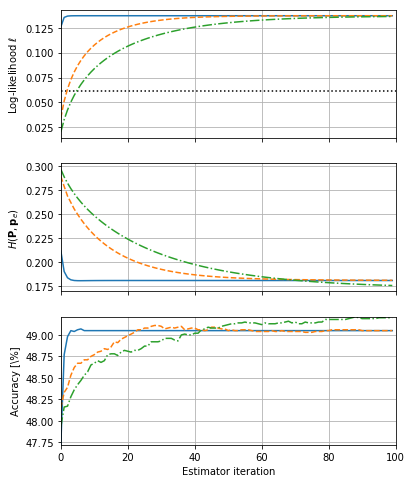

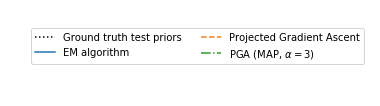

In [7]:
###############
# Plot results
###############
gt_likelihood = likelihood_fast(test_set_distribution, a, num_samples=gt.size)
    
plot_width = 6
plot_height = 8
        
fig=plt.figure(figsize=(plot_width, plot_height), facecolor='w', edgecolor='k')
plt.subplot(3,1,1)
plt.grid()
gt_handle, = plt.plot([0,num_iter], [gt_likelihood, gt_likelihood], 'k:')
em_handle, = plt.plot(likelihoods_em, 'C0', label='EM algorithm')
mle_handle, = plt.plot(likelihoods_mle, 'C1--', label='Projected Gradient Ascent')
map_handle, = plt.plot(likelihoods_map, 'C2-.', label='Projected Gradient Ascent MAP (Dirichlet alpha=3)')

plot_handles = [gt_handle, em_handle, mle_handle, map_handle]
plot_labels = [r'Ground truth test priors', 'EM algorithm', 'Projected Gradient Ascent', r'PGA (MAP, $\alpha=3$)']
        
plt.ylabel(r'Log-likelihood $\ell$')
plt.setp( plt.gca().get_xticklabels(), visible=False)
plt.xlim(0,num_iter)

plt.subplot(3,1,2)
plt.grid()
plt.plot(hellinger_distances_em, 'C0', label='EM algorithm')
plt.plot(hellinger_distances_mle, 'C1--', label='Projected Gradient Descent')
plt.plot(hellinger_distances_map, 'C2-.', label='Projected Gradient Descent (MAP, \alpha=3)')

plt.ylabel("$H(\mathbf{P}, \mathbf{p}_e)$")
plt.setp( plt.gca().get_xticklabels(), visible=False)
plt.xlim(0, num_iter)
        
        
plt.subplot(3,1,3)
plt.grid()
plt.plot(accuracies_em, 'C0', label='EM algorithm')
plt.plot(accuracies_mle, 'C1--', label='Projected Gradient Ascent')
plt.plot(accuracies_map, 'C2-.', label='Projected Gradient Ascent MAP (Dirichlet alpha=3)')

ymin = np.min([accuracies_em, accuracies_mle, accuracies_map])
ymax = np.max([accuracies_em, accuracies_mle, accuracies_map])
plt.ylim(ymin, ymax)
plt.xlim(0,num_iter)
        
plt.ylabel("Accuracy [\%]")
plt.xlabel("Estimator iteration")


# Plot legend separately
figLegend = plt.figure(2,figsize=(plot_width,1.3), frameon=False)
ax = plt.subplot()
ax.set_axis_off()
                       
plt.legend(plot_handles, plot_labels, frameon=True,loc='center', ncol=2)